In [48]:
import os
import pandas as ps
from pandas import DataFrame
import onshape.brepio as brepio
import json
from IPython.display import JSON as DJSON
from IPython.display import clear_output
import numpy as np
from utils import adjacency_list, adjacency_list_from_brepdata, connected_components, homogenize, adjacency_matrix
import sys
import time

### things to count:
- no mates
- disconnected components
- hisogram of number of moving parts

datalistpath = os.path.join('data', 'dof_assemblies.txt')
with open(datalistpath) as f:
    datalist = [[el[1] for el in enumerate(l.strip().split('/')[-7:]) if el[0] == 0 or el[0] == 4 or el[0] == 6] for l in f.readlines()]

## Make dataframes

In [2]:
datapath = '/projects/grail/benjones/cadlab'
loader = brepio.Loader(datapath)

In [3]:
generate_dataframes=False
name = '/fast/jamesn8/assembly_data/assembly_data_with_transforms_all.h5'
#start = 0
start = 125133

In [4]:
if generate_dataframes:
    
    if start == 0:
        with open('filter_list.txt') as f:
            filter_list = f.readlines()
        print('making filter set')
        filter_set = set()
        for l in filter_list:
            filter_set.add(l.strip())
        del filter_list

        valid_dict = dict()

        assembly_rows = []
        assembly_indices = []

        part_rows = []
        mate_rows = []

    j=0 #assembly id
    for entry in os.scandir(os.path.join(datapath,'data','flattened_assemblies')):
        #if j > 3:
        #    break
        if j < start:
            continue
        if not entry.name.endswith('.json') or entry.name in filter_set:
            continue

        occs, mates = loader.load_flattened(entry.name,geometry=False, skipInvalid=True)

        if j % 500 == 0:
            clear_output(wait=True)
            display(f'num_processed: {j}')

        adj_list = adjacency_list_from_brepdata(occs, mates)
        if len(adj_list) > 0:
            adj = homogenize(adj_list)
        else:
            adj = np.zeros([0,0],np.int32)
        num_lone = adj.shape[0] if adj.shape[1] == 0 else (adj[:,0] < 0).sum()
        #num_connections = np.sum(adj, 0)
        #num_lone = len([c for c in num_connections if c == 0])

        num_components = connected_components(adj)
        num_rigid = connected_components(adj, connectionType='fasten')

        num_part_mates = 0
        for mate in mates:
            if len(mate.matedEntities) == 2:
                num_part_mates += 1
                axes = []
                origins = []
                for me in mate.matedEntities:
                    #tf = occs[me[0]][0]
                    #newaxes = tf[:3, :3] @ me[1][1]
                    #neworigin = tf[:3,:3] @ me[1][0] + tf[:3,3]
                    axes.append(me[1][1])
                    origins.append(me[1][0])
                mate_rows.append([np.int32(j), mate.matedEntities[0][0], mate.matedEntities[1][0], mate.type, origins[0].astype(np.float32), axes[0].astype(np.float32), origins[1].astype(np.float32), axes[1].astype(np.float32), mate.name])

        assembly_rows.append([os.path.splitext(entry.name)[0], np.int32(num_components), np.int32(num_rigid), np.int32(num_lone), np.int32(len(occs)), np.int32(num_part_mates), np.int32(len(mates))])
        assembly_indices.append(np.int32(j)) 
        
        for occ in occs:
            part = occs[occ][1]
            did = part['documentId']
            mv = part['documentMicroversion']
            eid = part['elementId']
            config = part['fullConfiguration']
            if 'partId' in part:
                pid = part['partId']
            else:
                pid = ''
            filepath = os.path.join(did, mv, eid, config, f'{pid}.xt')
            
            if filepath in valid_dict:
                isValid = valid_dict[filepath]
            else:
                filepath = os.path.join(datapath, 'data/models', filepath)
                isValid = os.path.isfile(filepath)
                valid_dict[filepath] = isValid
            
            part_rows.append([np.int32(j), occ, did, mv, eid, config, pid, occs[occ][0].astype(np.float32), isValid])

        j += 1

    print('building dataframes...')
    assembly_df = DataFrame(assembly_rows, index=assembly_indices, columns=['AssemblyPath','ConnectedComponents','RigidPieces','LonePieces', 'NumParts', 'NumBinaryPartMates', 'TotalMates'])
    mate_df = DataFrame(mate_rows, columns=['Assembly','Part1','Part2','Type','Origin1','Axes1','Origin2','Axes2','Name'])
    part_df = DataFrame(part_rows, columns=['Assembly','PartOccurrenceID','did','mv','eid','config','PartId', 'Transform', 'HasGeometry'])

    print('saving dataframes...')
    assembly_df.to_hdf(name,'assembly')
    mate_df.to_hdf(name,'mate')
    part_df.to_hdf(name,'part')
    del assembly_rows
    del part_rows
    del mate_rows
    del assembly_indices
    del valid_dict
else:
    assembly_df = ps.read_hdf(name,'assembly')
    mate_df = ps.read_hdf(name,'mate')
    part_df = ps.read_hdf(name,'part')

### Generate statistics (if not already present)

In [7]:
def generate_statistics(assembly_df, part_df, mate_df):
    part_df_indexed = part_df.set_index('Assembly')
    mate_df_indexed = mate_df.set_index('Assembly')
    statistics = []

    for index in assembly_df.index:
        if index % 500 == 0:
            clear_output(wait=True)
            display(f'num_processed: {index}')

        try:
            parts = part_df_indexed.loc[index]
        except KeyError:
            occs = []
        else:
            if parts.ndim == 2:
                occs = list(parts['PartOccurrenceID'])
            else:
                occs = [parts['PartOccurrenceID']]

        try:
            mates = mate_df_indexed.loc[index]
        except KeyError:
            mates_tuples = []
        else:
            if mates.ndim == 2:
                mates_tuples = [(row[0], row[1], row[2]) for row in mates.itertuples(index=False)]
            else:
                mates_tuples = [(mates[0], mates[1], mates[2])]
        if len(occs) == 0:
            statistics.append([0, 0, 0])
        else:
            adj_list = adjacency_list(occs, mates_tuples)
            adj = homogenize(adj_list)
            num_lone = adj.shape[0] if adj.shape[1] == 0 else len([el for el in adj[:,0] if el < 0])
            num_components = connected_components(adj)
            num_rigid = connected_components(adj, connectionType='fasten')
            #print('num_rigid',num_rigid)
            #print('num_components',num_components)
            #print('num_lone',num_lone)
            statistics.append([num_components,num_rigid,num_lone])
    statistics_np = np.array(statistics)
    assembly_df['ConnectedComponents'] = statistics_np[:,0]
    assembly_df['RigidComponents'] = statistics_np[:,1]
    assembly_df['LoneParts'] = statistics_np[:,2]

fixedname = '/fast/jamesn8/assembly_data/assembly_data2.h5'

assembly_df.to_hdf(fixedname,'assembly','w')

mate_df.to_hdf(fixedname,'mate','r+')
part_df_fixed.to_hdf(fixedname,'part','r+')

### Incorporate Deduplication

In [7]:
deduped_df = ps.read_parquet(os.path.join(datapath, 'data/deduped_assembly_list.parquet'))
deduped_df.drop('is_unique', axis=1, inplace=True)
deduped_df['AssemblyPath'] = ['_'.join(me) for me in zip(deduped_df['assembly_documentId'], deduped_df['assembly_documentMicroversion'], deduped_df['assembly_elementId'])]
deduped_df.set_index('AssemblyPath', inplace=True)
deduped_df_joined = assembly_df.join(deduped_df, on='AssemblyPath', how='inner')
deduped_df_joined['HasAllGeometry'] = part_df.groupby('Assembly')['HasGeometry'].agg(all).loc[deduped_df_joined.index]

In [8]:
deduped_df_filtered = deduped_df_joined[lambda df: df['HasAllGeometry']]
deduped_df_movingparts = deduped_df_filtered[lambda df: df['RigidPieces'] > 1]
deduped_df_movingparts_connected = deduped_df_movingparts[lambda df: df['ConnectedComponents'] == 1]

In [9]:
print(f'Total non-subassemblies: %d' % assembly_df.shape[0])
print(f'Total deduplicated non-sub-assemblies: %d (%.2f%%)' % (deduped_df_joined.shape[0], deduped_df_joined.shape[0]/assembly_df.shape[0]*100))
print(f'Total deduplicated with all geometry: %d (%.2f%%)' % (deduped_df_filtered.shape[0], deduped_df_filtered.shape[0]/assembly_df.shape[0]*100))
num_with_multiple_rigid = deduped_df_movingparts.shape[0]
num_fully_connected = sum(deduped_df_filtered['ConnectedComponents'] == 1)
num_fully_connected_multiple_rigid = deduped_df_movingparts_connected.shape[0]

print(f'Assemblies with more than 1 rigid piece: %d (%.2f %% of deduplicated assemblies)' % (num_with_multiple_rigid, num_with_multiple_rigid/deduped_df_filtered.shape[0]*100))
#print(f'Assemblies fully connected: %d (%.2f %% of deduplicated assemblies)' % (num_with_multiple_rigid, num_with_multiple_rigid/deduped_df_filtered.shape[0]*100))
print(f'Assemblies with more than 1 rigid piece that are fully connected: %d (%.2f %% of assemblies with more than 1 rigid piece)' % (num_fully_connected_multiple_rigid, num_fully_connected_multiple_rigid/num_with_multiple_rigid*100))

Total non-subassemblies: 125133
Total deduplicated non-sub-assemblies: 82333 (65.80%)
Total deduplicated with all geometry: 48877 (39.06%)
Assemblies with more than 1 rigid piece: 35806 (73.26 % of deduplicated assemblies)
Assemblies with more than 1 rigid piece that are fully connected: 26953 (75.28 % of assemblies with more than 1 rigid piece)


# Multi-mate analysis
**Notes**:
- Multi-mates containing a fasten are considered a fasten (but still counted)
- exact duplicate mates have been removed for this analysis
### Filter out mates with the same part

In [10]:
mate_df_filtered = mate_df[mate_df['Part1'] != mate_df['Part2']]

### Filter out duplicates

In [11]:
flattened_mateinfo = mate_df_filtered[['Origin1','Origin2','Axes1','Axes2']].apply(lambda x: [tuple(l.flatten()) for l in x])

In [12]:
flattened_mateinfo['Assembly'] = mate_df_filtered['Assembly']
flattened_mateinfo['Part1'] = mate_df_filtered['Part1']
flattened_mateinfo['Part2'] = mate_df_filtered['Part2']
flattened_mateinfo['Type'] = mate_df_filtered['Type']

In [13]:
mate_exact_duplicates = flattened_mateinfo.duplicated(keep='first')

In [14]:
mate_exact_duplicates.sum()

2403

In [15]:
mate_df_filtered = mate_df_filtered[~mate_exact_duplicates]

### Analyze mates between the same parts

In [16]:
mate_dofs = DataFrame(np.array([
    [0,0,0,0,0,0],
    [0,0,0,0,0,1],
    [0,0,1,0,0,0],
    [1,1,0,0,0,1],
    [0,0,1,0,0,1],
    [0,0,0,1,1,1],
    [1,1,1,0,0,1],
    [1,0,0,0,0,1]
]),index=['FASTENED','REVOLUTE','SLIDER','PLANAR','CYLINDRICAL','BALL','PARALLEL','PIN_SLOT'],columns=['pos1','pos2','pos3','rot1','rot2','rot3'])

In [17]:
mate_dofs_reverse = mate_dofs.copy()
mate_dofs_reverse['Type'] = mate_dofs.index
mate_dofs_reverse = mate_dofs_reverse.set_index(['pos1','pos2','pos3','rot1','rot2','rot3'])

In [18]:
mate_df_indexed = mate_df_filtered.copy()

In [19]:
mate_df_indexed['MateID'] = [str(tup[0]) + '-' + '-'.join(sorted(tup[1:])) for tup in zip(mate_df_indexed['Assembly'], mate_df_indexed['Part1'], mate_df_indexed['Part2'])]

In [20]:
mate_df_indexed.set_index('MateID', inplace=True)
duplicate_indices = mate_df_indexed.index.duplicated(False)

In [21]:
mate_duplicates = mate_df_indexed[duplicate_indices]

In [22]:
multimate_groups = mate_duplicates.groupby(by='MateID')

In [23]:
def prod(lst):
    accum = lst[0].copy()
    for l in lst[1:]:
        accum *= l
    return accum

In [24]:
def join_subtractive(x):
    pos = 3
    rot = 3
    for dof in x:
        dofi = mate_dofs.loc[dof]
        pos_c = 3-dofi[:3].sum()
        rot_c = 3-dofi[3:].sum()
        pos -= pos_c
        rot -= rot_c
    return (max(0,pos), max(0,rot))

In [25]:
aggregated = multimate_groups.agg({'Type':lambda x: 'FASTENED' if 'FASTENED' in list(x) else '-'.join(sorted(list(x))),'Assembly':lambda x:x[0]})

In [26]:
all_groups = mate_df_indexed.groupby(by='MateID')
all_aggregated = all_groups.agg({'Type':lambda x:'-'.join(sorted(list(x))),'Assembly':lambda x:x[0]})

In [27]:
def mate_counts(aggregated_df, keys):
    newkeys = aggregated_df.index.intersection(keys)
    type_values = all_aggregated_by_assembly.loc[newkeys, 'Type']
    flattened = []
    for t in type_values:
        for k in t.split('-'):
            flattened.append(k)
    return type_values.value_counts(), ps.Series(flattened).value_counts()

In [28]:
all_aggregated_by_assembly = all_aggregated.set_index('Assembly')

In [29]:
assemblies_with_multimates = aggregated.set_index('Assembly').index.unique()

In [30]:
index_with_moving_parts_no_multimates = deduped_df_movingparts.index.difference(assemblies_with_multimates)
num_with_moving_parts_no_multimates = len(index_with_moving_parts_no_multimates)
index_fully_connected_moving_no_multimates = deduped_df_movingparts_connected.index.difference(assemblies_with_multimates)
num_fully_connected_moving_no_multimates = len(index_fully_connected_moving_no_multimates)
print(f'Moving assemblies with no multimates: %d (%.2f%% of moving assemblies)' % (num_with_moving_parts_no_multimates, num_with_moving_parts_no_multimates/deduped_df_movingparts.shape[0]*100))
print(f'Moving connected assemblies with no multimates: %d (%.2f%% of moving assemblies)' % (num_fully_connected_moving_no_multimates, num_fully_connected_moving_no_multimates/deduped_df_movingparts.shape[0]*100))

Moving assemblies with no multimates: 27963 (78.10% of moving assemblies)
Moving connected assemblies with no multimates: 20845 (58.22% of moving assemblies)


In [36]:
with open('fully_connected_moving_no_multimates.txt','w') as f:
    for ind in index_fully_connected_moving_no_multimates:
        f.write(f'{ind}\n')

In [31]:
counts_A, counts_A_flattened = mate_counts(all_aggregated_by_assembly, deduped_df_filtered.index)

In [32]:
counts_B, counts_B_flattened = mate_counts(all_aggregated_by_assembly, deduped_df_movingparts.index)

In [33]:
counts_C, counts_C_flattened = mate_counts(all_aggregated_by_assembly, deduped_df_movingparts_connected.index)

In [34]:
counts_D, counts_D_flattened = mate_counts(all_aggregated_by_assembly, index_with_moving_parts_no_multimates)

In [35]:
counts_E, counts_E_flattened = mate_counts(all_aggregated_by_assembly, index_fully_connected_moving_no_multimates)

<AxesSubplot:title={'center':'A'}>

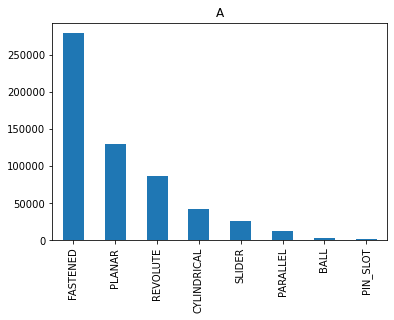

In [253]:
counts_A_flattened.plot.bar(title='A')

<AxesSubplot:title={'center':'B'}>

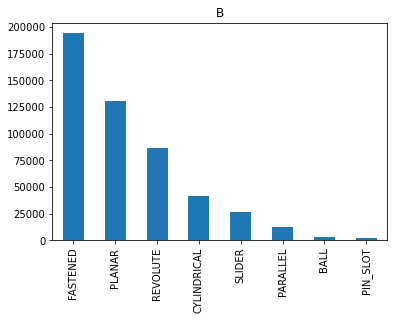

In [254]:
counts_B_flattened.plot.bar(title='B')

<AxesSubplot:title={'center':'C'}>

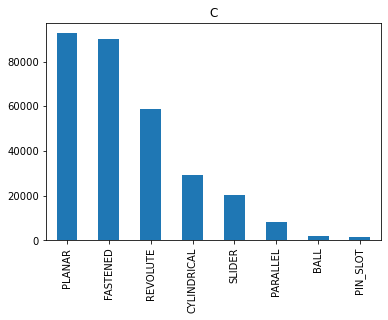

In [255]:
counts_C_flattened.plot.bar(title='C')

<AxesSubplot:title={'center':'D'}>

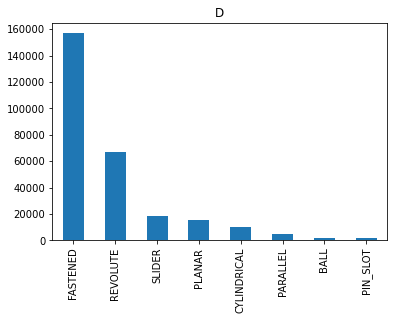

In [256]:
counts_D_flattened.plot.bar(title='D')

<AxesSubplot:title={'center':'E'}>

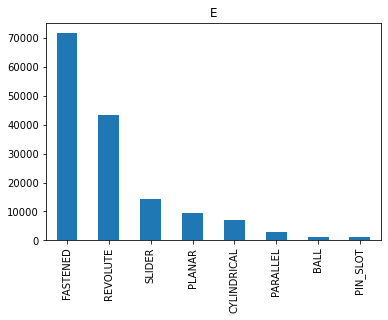

In [257]:
counts_E_flattened.plot.bar(title='E')

In [28]:
def numUnique(lst):
    s = set()
    for l in lst:
        s.add(l)
    return len(s)

In [29]:
all_mate_counts = all_aggregated.groupby('Type').agg({'Assembly':['count',numUnique]})['Assembly'].rename(columns={'numUnique':'numAssemblies'}).sort_values('count', ascending=False)

In [ ]:
all_mate_counts[[len(t.split('-')) == 1 for t in all_mate_counts.index]]

In [ ]:
all_mate_counts[['PARALLEL' in t.split('-') for t in all_mate_counts.index]].to_csv('parallels.csv')

In [83]:
aggregated_dofs = multimate_groups.agg({'Type':lambda x: tuple(prod([mate_dofs.loc[t].to_numpy() for t in x])),'Assembly':lambda x:x[0]})

In [98]:
aggregated_dofs2 = multimate_groups.agg({'Type':join_subtractive,'Assembly':lambda x:x[0]})

In [99]:
aggregated_dofs2

,Type,Assembly
MateID,,
10-MMb6JZl4ks61uaBwr-MS8WYyXlytoCXG1pZ,"(0, 0)",10
100000-Mq3qURmAJRvJ7SkpJ-Mv2mXrkaVwkPdzJ6s,"(1, 0)",100000
100009-M1Qk600l46srC1L9e-MCKAHW47mIKm/jCuX,"(1, 0)",100009
100016-M8SI7IaWgOJefLadF-MAgQILhjNgXd0pkaS,"(0, 0)",100016
10002-M6+nLPUTeSkfTS+cD-MjYZemYeVhYjQHg3D,"(0, 0)",10002
...,...,...
99999-MEwYaMSyoEtu00KHO-MLebwGRtTggG9fr7L,"(0, 0)",99999
99999-MMUKcXHqa3zNhRRa0-MbsnSbKBpxq/hQfTr,"(0, 0)",99999
99999-MRwbE7U4t/0IFUKdz-MdvGdYpK+TZjjQ6iF,"(0, 0)",99999


In [36]:
multimate_counts = aggregated.groupby('Type').agg({'Assembly':['count',numUnique]})['Assembly'].rename(columns={'numUnique':'numAssemblies'}).sort_values('count', ascending=False)

In [86]:
dof_counts = aggregated_dofs.groupby('Type').agg({'Assembly':['count',numUnique]})['Assembly'].rename(columns={'numUnique':'numAssemblies'}).sort_values('count', ascending=False)

In [93]:
dof_counts['Type'] = [mate_dofs_reverse.loc[t] for t in dof_counts.index]
dof_counts = dof_counts.set_index('Type')
dof_counts

,count,numAssemblies
Type,,
[PLANAR],59002,10803
[REVOLUTE],42518,8370
[FASTENED],12856,5281
[CYLINDRICAL],2646,1468
[SLIDER],1109,778
[PARALLEL],1012,663
[BALL],489,131
[PIN_SLOT],422,249


In [101]:
dof_counts2 = aggregated_dofs2.groupby('Type').agg({'Assembly':['count',numUnique]})['Assembly'].rename(columns={'numUnique':'numAssemblies'}).sort_values('count', ascending=False)
#dof_counts2['Type'] = [mate_dofs_reverse.loc[t] for t in dof_counts.index]
#dof_counts2 = dof_counts.set_index('Type')
dof_counts2

,count,numAssemblies
Type,,
"(0, 0)",83550,17720
"(1, 0)",30947,7927
"(2, 0)",3541,1198
"(3, 0)",1012,663
"(0, 1)",515,269
"(0, 3)",489,131


In [45]:
multimate_counts = multimate_counts[multimate_counts.index != 'FASTENED']

In [47]:
multimate_counts.to_csv('multimates-nodups.csv')

In [46]:
for index in multimate_counts.index:
    print(index,list(multimate_counts.loc[index]))

PLANAR-PLANAR [28839, 7060]
CYLINDRICAL-PLANAR [27654, 5485]
PLANAR-PLANAR-PLANAR [25096, 6521]
CYLINDRICAL-CYLINDRICAL-PLANAR [4707, 1378]
PLANAR-SLIDER [3897, 1488]
PARALLEL-PLANAR [3298, 1107]
REVOLUTE-REVOLUTE [2684, 927]
PLANAR-REVOLUTE [2166, 591]
CYLINDRICAL-CYLINDRICAL [1649, 903]
CYLINDRICAL-PARALLEL-PLANAR [1522, 565]
CYLINDRICAL-PLANAR-PLANAR [1199, 494]
CYLINDRICAL-PARALLEL [885, 552]
PARALLEL-PARALLEL [823, 574]
PARALLEL-PLANAR-PLANAR [760, 368]
PARALLEL-REVOLUTE [707, 413]
CYLINDRICAL-REVOLUTE [667, 381]
BALL-BALL [486, 129]
SLIDER-SLIDER [485, 339]
BALL-CYLINDRICAL [334, 138]
PLANAR-PLANAR-PLANAR-PLANAR [315, 216]
PARALLEL-SLIDER [272, 226]
CYLINDRICAL-SLIDER [264, 179]
PARALLEL-PARALLEL-PLANAR [210, 131]
PLANAR-SLIDER-SLIDER [177, 115]
PLANAR-PLANAR-SLIDER [172, 99]
PARALLEL-PARALLEL-PARALLEL-PLANAR-PLANAR-PLANAR [163, 14]
PARALLEL-PARALLEL-PARALLEL [158, 116]
REVOLUTE-SLIDER [143, 106]
PIN_SLOT-PLANAR [139, 62]
PARALLEL-PLANAR-PLANAR-PLANAR [136, 121]
PIN_SLOT-PIN_SLOT

In [57]:
assemblies_with_multimates = set(aggregated['Assembly'])

In [61]:
len(assemblies_with_multimates)/assembly_df.shape[0]

0.18878114536678697

In [51]:
1-multimate_counts['numAssemblies'][20:].sum() / multimate_counts['numAssemblies'][:20].sum()

0.9152181983867157

In [32]:
1-multimate_counts['count'][20:].sum() / multimate_counts['count'][:20].sum()

NameError: name 'multimate_counts' is not defined

# Heuristics

In [101]:
stats_path = '/fast/jamesn8/assembly_data/mate_torch_stats/'
stats_df = ps.concat([ps.read_parquet(os.path.join(stats_path, fname)) for fname in os.listdir(stats_path) if fname.startswith('stats') and fname.endswith('.parquet')], axis=0)
mate_stats_df = ps.concat([ps.read_parquet(os.path.join(stats_path, fname)) for fname in os.listdir(stats_path) if fname.startswith('mate') and fname.endswith('.parquet')], axis=0)

In [102]:
recorded_mates = mate_stats_df[lambda df: ~df['mc_pair_found'].isnull()]
recorded_mates['total_extra_matches'] = recorded_mates['extra_matches_frame_0'] + recorded_mates['extra_matches_frame_1']

/tmp/ipykernel_1761636/3224859321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recorded_mates['total_extra_matches'] = recorded_mates['extra_matches_frame_0'] + recorded_mates['extra_matches_frame_1']


In [111]:
recorded_assemblies = stats_df[lambda df: ~df['missed_mc_pairs'].isnull()]

In [103]:
mate_stats_df.keys()

Index(['invalid_frame_0', 'invalid_frame_0_coincident_origins',
       'invalid_frame_0_permuted_z', 'matches_frame_0',
       'extra_matches_frame_0', 'invalid_frame_1',
       'invalid_frame_1_coincident_origins', 'invalid_frame_1_permuted_z',
       'matches_frame_1', 'extra_matches_frame_1', 'type',
       'truncated_mc_pairs', 'part_pair_found', 'mc_pair_found'],
      dtype='object')

In [104]:
stats_df.keys()

Index(['total_mates', 'total_parts', 'maxdim', 'total_mcs', 'invalid_frames',
       'invalid_mates', 'invalid_coincident_origins', 'invalid_permuted_z',
       'false_part_pairs', 'missed_part_pairs', 'missed_mc_pairs',
       'num_invalid_transformed_parts', 'num_proposals', 'proposal_time'],
      dtype='object')

types of mates with invalid frames:


<AxesSubplot:>

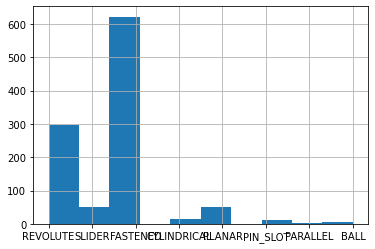

In [105]:
print('types of mates with invalid frames:')
invalid_frames['type'].hist()

In [128]:
invalid_frames = mate_stats_df[lambda df: df['invalid_frame_0'] | df['invalid_frame_1']]
assemblies_with_invalid_frames = stats_df[lambda df: df['invalid_mates'] > 0]
print(f'fraction of mates with an unmatched mate frame:{invalid_frames.shape[0]/mate_stats_df.shape[0]}')
print(f'fraction of assemblies with unmatched mate frames:{assemblies_with_invalid_frames.shape[0]/stats_df.shape[0]}')
#invalid_frames_with_coincident_origins = invalid_frames[lambda df: df['invalid_frame_0_coincident_origins'] | df['invalid_frame_1_coincident_origins']]
#invalid_frames_with_coincident_origins[lambda df: df['invalid_frame_0_permuted_z'] | df['invalid_frame_1_permuted_z']].shape[0]/invalid_frames_with_coincident_origins.shape[0]
#invalid_frames_with_coincident_origins.shape[0]/invalid_frames.shape[0]
missed_mates = recorded_mates[lambda df: ~df['mc_pair_found'].astype(bool)]
missed_part_pairs = recorded_mates[lambda df: ~df['part_pair_found'].astype(bool)]
print(f'fraction of mated connector pairs missed by heuristics: {missed_mates.shape[0]/recorded_mates.shape[0]}')
print(f'fraction of mated part pairs completely missed by heuristics: {missed_part_pairs.shape[0]/recorded_mates.shape[0]}')
print(f'average fraction of mates that are missed by heuristics per assembly: {(recorded_assemblies["missed_mc_pairs"]/recorded_assemblies["total_mates"]).mean()}')
print(f'rate of assemblies with at least one mate missed by heuristics: {recorded_assemblies[lambda df: df["missed_mc_pairs"] > 0].shape[0]/recorded_assemblies.shape[0]}')
print(f'fraction of mates with more than 100000 mated pairs found by heuristics: {mate_stats_df["truncated_mc_pairs"].sum()/mate_stats_df.shape[0]}')
print(f'average number of connector pair proposals per assembly: {recorded_assemblies["num_proposals"].mean()}')

fraction of mates with an unmatched mate frame:0.1454008183058039
fraction of assemblies with unmatched mate frames:0.25062531265632815
fraction of mated connector pairs missed by heuristics: 0.05213831735430357
fraction of mated part pairs completely missed by heuristics: 0.05063018420769148
average fraction of mates that are missed by heuristics per assembly: 0.09275763664751584
rate of assemblies with at least one mate missed by heuristics: 0.1307519640852974
fraction of mates with more than 100000 mated pairs found by heuristics: 0.003106531292620094
average number of connector pair proposals per assembly: 54196.80808080808


<AxesSubplot:title={'center':'Heuristic precision per mate type'}, xlabel='type'>

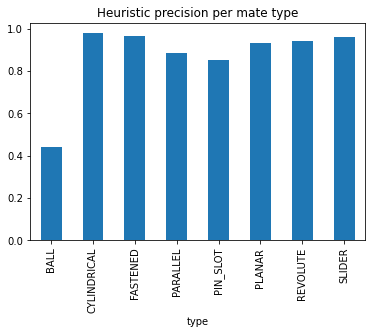

In [135]:
per_type_stats = recorded_mates.groupby('type').agg({'mc_pair_found': sum, 'type': 'count'})
(per_type_stats['mc_pair_found']/per_type_stats['type']).plot.bar(title='Heuristic precision per mate type')

/tmp/ipykernel_1761636/1597843885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recorded_mates['valid'] = ~(recorded_mates['invalid_frame_0'] | recorded_mates['invalid_frame_1'])


<AxesSubplot:title={'center':'Percent of mates correspond to any connectors per mate type'}, xlabel='type'>

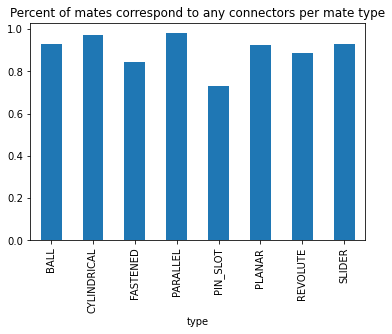

In [136]:
recorded_mates['valid'] = ~(recorded_mates['invalid_frame_0'] | recorded_mates['invalid_frame_1'])
per_type_stats = recorded_mates.groupby('type').agg({'valid': sum, 'type': 'count'})
(per_type_stats['valid']/per_type_stats['type']).plot.bar(title='Percent of mates correspond to any connectors per mate type')

<AxesSubplot:title={'center':'Number of extra MC pair matches per mate type'}, xlabel='type'>

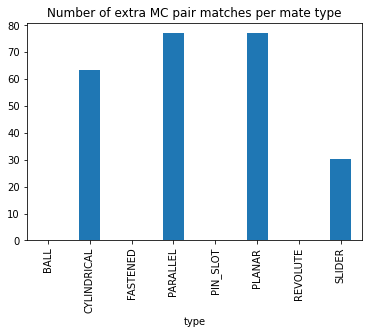

In [107]:
recorded_mates.groupby('type')['total_extra_matches'].agg(np.mean).plot.bar(title='Number of extra MC pair matches per mate type')

number of mates missed by heuristics, by type


<AxesSubplot:>

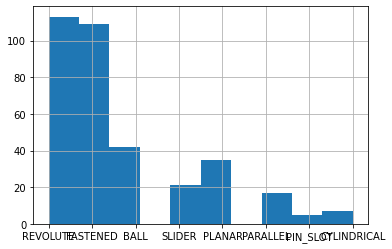

In [90]:
print('number of mates missed by heuristics, by type')
missed_mates['type'].hist()

# Legacy statistics

In [ ]:
skipped = 0

#number of assemblies with lone pieces

c_num_lone_pieces = []

#number of assemblies with disconnected components

c_num_components = []

#number of parts in fully connected assemblies

c_num_parts_connected = []

#number of rigid components in fully connected assemblies

c_num_rigid_connected = []

#same, but without the condition?

c_num_parts = []

c_num_rigid = []

#for data in datalist:
for j,entry in enumerate(os.scandir(os.path.join(datapath,'data','flattened_assemblies'))):
    if j % 1000 == 0:
        print(j)
    if not entry.name.endswith('.json') or entry.name in filter_set:
        continue
    try:
        #occs, mates = loader.load(data[0], data[1], data[2], geometry=False)
        occs, mates = loader.load_flattened(entry.path, geometry=False)
    except KeyError as e:
        #print(e)
        skipped += 1
        continue
    except FileNotFoundError as e:
        #print(e)
        skipped += 1
        continue
    #print(occs, mates)
    adj = adjacency_matrix(occs, mates)
    num_connections = np.sum(adj, 0)
    num_lone = len([c for c in num_connections if c == 0])
    c_num_lone_pieces.append(num_lone)
    
    num_components = connected_components(adj)
    num_rigid = connected_components(adj, connectionType='fasten')
    c_num_components.append(num_components)
    
    c_num_rigid.append(num_rigid)
    c_num_parts.append(adj.shape[0])
    if num_components == 1:
        c_num_parts_connected.append(adj.shape[0])
        c_num_rigid_connected.append(num_rigid)

    
    
print('skipped',skipped)

In [ ]:
num_with_lone_pieces = len([c for c in c_num_lone_pieces if c > 0])
num_fully_connected = len([c for c in c_num_components if c == 1])
num_processed = len(c_num_parts)
print('number of assemblies processed: %d'%num_processed)
print('assemblies with lone pieces: %d (%.2f%%)'%(num_with_lone_pieces, num_with_lone_pieces/num_processed*100))
print('assemblies fully connected: %d (%.2f%%)'%(num_fully_connected, num_fully_connected/num_processed*100))
nbins = 40
plt.hist(c_num_parts, nbins, range=(0, nbins+1))
plt.title('num parts')
plt.show()
plt.hist(c_num_rigid, nbins, range=(0,nbins+1))
plt.title('num rigid components')
plt.show()
plt.hist(c_num_parts_connected, nbins, range=(0, nbins+1))
plt.title('num parts in connected models')
plt.show()
plt.hist(c_num_rigid_connected, nbins, range=(0, nbins+1))
plt.title('num rigid components in connected models')
plt.show()
plt.hist(c_num_lone_pieces, nbins, range=(0, nbins+1))
plt.title('num lone pieces')
plt.show()
plt.hist(c_num_components, nbins, range=(0, nbins+1))
plt.title('num connected components')
plt.show()


In [ ]:
len([c for c in c_num_rigid_connected if c >= 2])

In [ ]:
len([c for c in c_num_parts_connected if c == 2])

In [ ]:
num_with_more_than_2_rigid = len([c for c in c_num_rigid_connected if c > 2])
print(num_with_more_than_2_rigid)
print(num_with_more_than_2_rigid/num_processed*100)

In [ ]:
num_with_more_than_2_parts = len([c for c in c_num_parts_connected if c > 2])
print(num_with_more_than_2_parts)
print(num_with_more_than_2_parts/num_processed*100)

In [ ]:
num_with_lone_parts = len([c for c in c_num_lone_pieces if c > 0])
print(num_with_lone_parts)
print(num_with_lone_parts/num_processed*100)